In [ ]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt



In [ ]:
# Ensure that NLTK's stopwords and other resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
file_path = '/content/zcleaned reddit  (1).csv'  # Update the path accordingly
df = pd.read_csv(file_path)

In [ ]:
def preprocess_text(text):
    result = simple_preprocess(text, deacc=True)  # Tokenize and de-accent
    stop_words = set(stopwords.words('english'))
    result = [word for word in result if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(word) for word in result]
    return result

df['processed_comments'] = df['comment'].apply(preprocess_text)

In [ ]:
bigram = gensim.models.Phrases(df['processed_comments'], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[df['processed_comments']], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)
df['trigrams'] = df['processed_comments'].map(lambda tokens: trigram_mod[bigram[tokens]])

dictionary = corpora.Dictionary(df['trigrams'])
corpus = [dictionary.doc2bow(text) for text in df['trigrams']]

In [ ]:
from gensim.models import LdaModel

# Adjusted part of the code for training LDA models with more iterations and passes
coherence_values = []
model_list = []
for num_topics in range(2, 21):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                     passes=10, iterations=400)  # Increased passes and iterations
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=df['trigrams'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


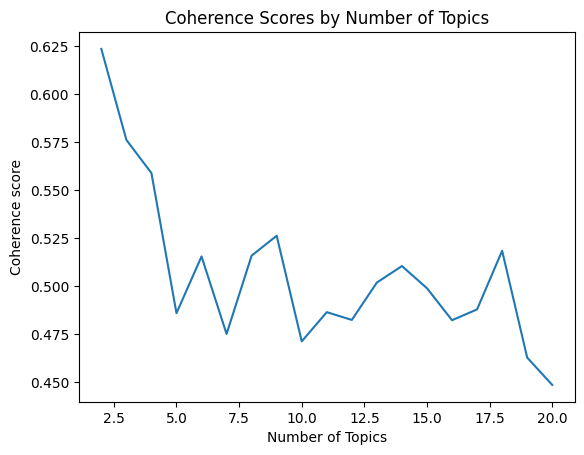

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(2, 21), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Number of Topics")
plt.show()


In [ ]:
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]

# Display the topics
topics = optimal_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.034*"car" + 0.012*"one" + 0.010*"get" + 0.009*"like" + 0.008*"year" + 0.007*"would" + 0.006*"insurance" + 0.006*"think" + 0.006*"drive" + 0.005*"good"')
(1, '0.009*"people" + 0.007*"one" + 0.005*"like" + 0.005*"would" + 0.004*"know" + 0.004*"someone" + 0.004*"post" + 0.004*"said" + 0.004*"always" + 0.004*"company"')


In [ ]:
# Assuming 'optimal_model' is your selected model from the output
topics = optimal_model.print_topics(num_words=10)
for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}\n")


Topic 0: 0.034*"car" + 0.012*"one" + 0.010*"get" + 0.009*"like" + 0.008*"year" + 0.007*"would" + 0.006*"insurance" + 0.006*"think" + 0.006*"drive" + 0.005*"good"

Topic 1: 0.009*"people" + 0.007*"one" + 0.005*"like" + 0.005*"would" + 0.004*"know" + 0.004*"someone" + 0.004*"post" + 0.004*"said" + 0.004*"always" + 0.004*"company"



In [ ]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.9 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)


In [ ]:
import pandas as pd

# Load the marketing topics from the CSV file
marketing_topics_df = pd.read_csv('/content/Fiat_Dolcevita_Marketing_Topics_75_Words.csv')

# Display the first few rows to understand the structure and content
print(marketing_topics_df.head())


   Topic Number                                          Top Words
0             0  design, chrome, elegant, panoramic, exterior, ...
1             1  italian, accessories, confidence, using, cloth...
2             2  cruise, control, features, driver, assistance,...
3             3  la, dolce, vita, dolcevita, like, negroni, pre...
4             4  control, cruise, adaptive, experience, lane, l...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
